<a href="https://colab.research.google.com/github/Sriyansh-00/IMAGE-CLASSIFICATION-MODEL/blob/main/image_classificaton_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# First install kaggle API
!pip install -q kaggle

# Upload the kaggle.json file you just downloaded
from google.colab import files
uploaded = files.upload()  # This will prompt you to select the kaggle.json file

# Move the file to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Verify it worked
!ls ~/.kaggle

Saving kaggle.json to kaggle.json
kaggle.json


In [11]:
# Download the dataset
!kaggle datasets download -d puneet6060/intel-image-classification

# Unzip it
!unzip intel-image-classification.zip -d intel_images

# Verify the files exist
!ls intel_images

Streaming output truncated to the last 5000 lines.
  inflating: intel_images/seg_train/seg_train/mountain/7537.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7539.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7551.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7560.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7565.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7578.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7581.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7586.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7647.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7652.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7654.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7662.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/767.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7672.jpg  
  inflating: intel_images/

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Set paths
train_dir = '/content/intel_images/seg_train/seg_train'
test_dir = '/content/intel_images/seg_test/seg_test'

# Image parameters
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

In [13]:
# Training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Validation data (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)  # Important for evaluation

class_names = list(train_generator.class_indices.keys())

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


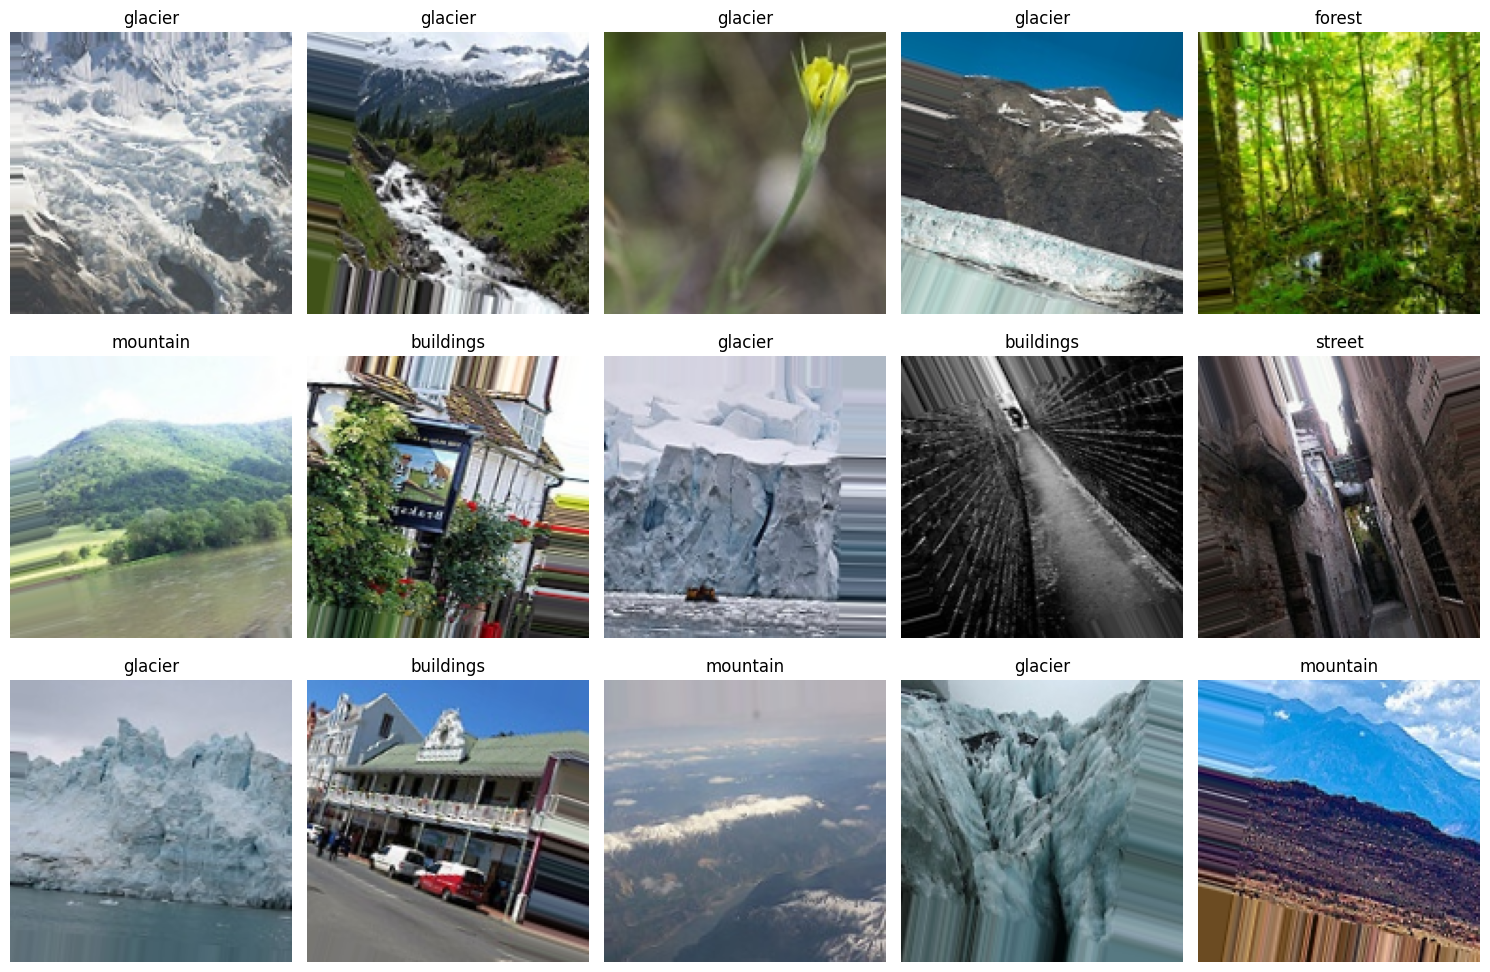

In [14]:
# Display sample images
def plot_images(images_arr, titles=None):
    fig, axes = plt.subplots(3, 5, figsize=(15, 10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        if titles is not None:
            ax.set_title(titles[ax.get_subplotspec().num1])
    plt.tight_layout()
    plt.show()

sample_images, sample_labels = next(train_generator)
sample_titles = [class_names[np.argmax(label)] for label in sample_labels]
plot_images(sample_images[:15], sample_titles[:15])

In [15]:
model = models.Sequential([
    # Convolutional Base
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    # Classifier Head
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(6, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,814,534 (26.00 MB)

 Trainable params: 6,814,534 (26.00 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=15,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 833s 2s/step - accuracy: 0.4773 - loss: 1.2921 - val_accuracy: 0.6253 - val_loss: 0.9984
Epoch 2/15
  1/438 ━━━━━━━━━━━━━━━━━━━━ 15:00 2s/step - accuracy: 0.6250 - loss: 0.8643

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


438/438 ━━━━━━━━━━━━━━━━━━━━ 81s 181ms/step - accuracy: 0.6250 - loss: 0.8643 - val_accuracy: 0.5531 - val_loss: 1.2757
Epoch 3/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 819s 2s/step - accuracy: 0.6407 - loss: 0.9310 - val_accuracy: 0.7376 - val_loss: 0.7496
Epoch 4/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 81s 181ms/step - accuracy: 0.6875 - loss: 0.8454 - val_accuracy: 0.7285 - val_loss: 0.7581
Epoch 5/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 863s 2s/step - accuracy: 0.7039 - loss: 0.7841 - val_accuracy: 0.7796 - val_loss: 0.5945
Epoch 6/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 81s 181ms/step - accuracy: 0.7500 - loss: 0.8117 - val_accuracy: 0.7823 - val_loss: 0.5985
Epoch 7/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 922s 2s/step - accuracy: 0.7492 - loss: 0.6899 - val_accuracy: 0.7658 - val_loss: 0.6142
Epoch 8/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - accuracy: 0.7500 - loss: 0.6425 - val_accuracy: 0.7698 - val_loss: 0.6063
Epoch 9/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 862s 2s/step - accuracy: 0.7643 - loss: 0.6453 - val_accuracy

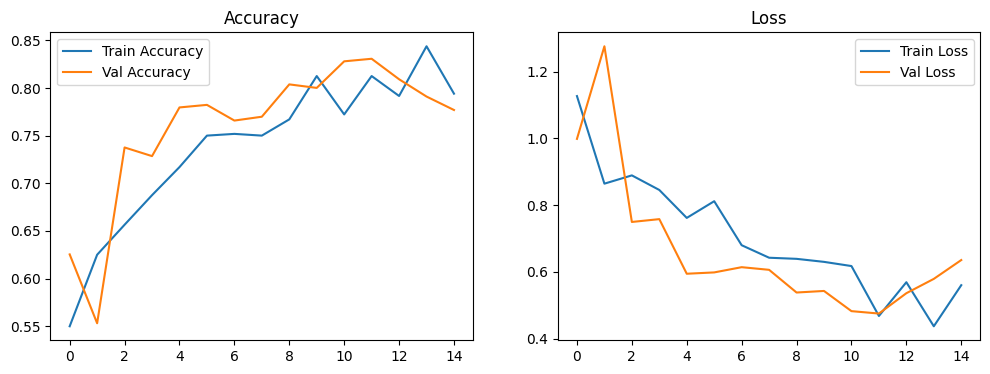

94/94 ━━━━━━━━━━━━━━━━━━━━ 43s 459ms/step - accuracy: 0.8146 - loss: 0.5229

Test Accuracy: 77.63%


In [17]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

94/94 ━━━━━━━━━━━━━━━━━━━━ 43s 455ms/step


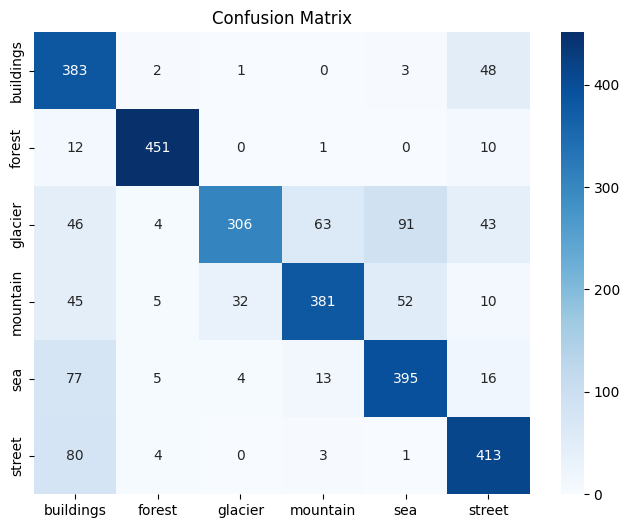


Classification Report:
              precision    recall  f1-score   support

   buildings       0.60      0.88      0.71       437
      forest       0.96      0.95      0.95       474
     glacier       0.89      0.55      0.68       553
    mountain       0.83      0.73      0.77       525
         sea       0.73      0.77      0.75       510
      street       0.76      0.82      0.79       501

    accuracy                           0.78      3000
   macro avg       0.79      0.78      0.78      3000
weighted avg       0.80      0.78      0.78      3000

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


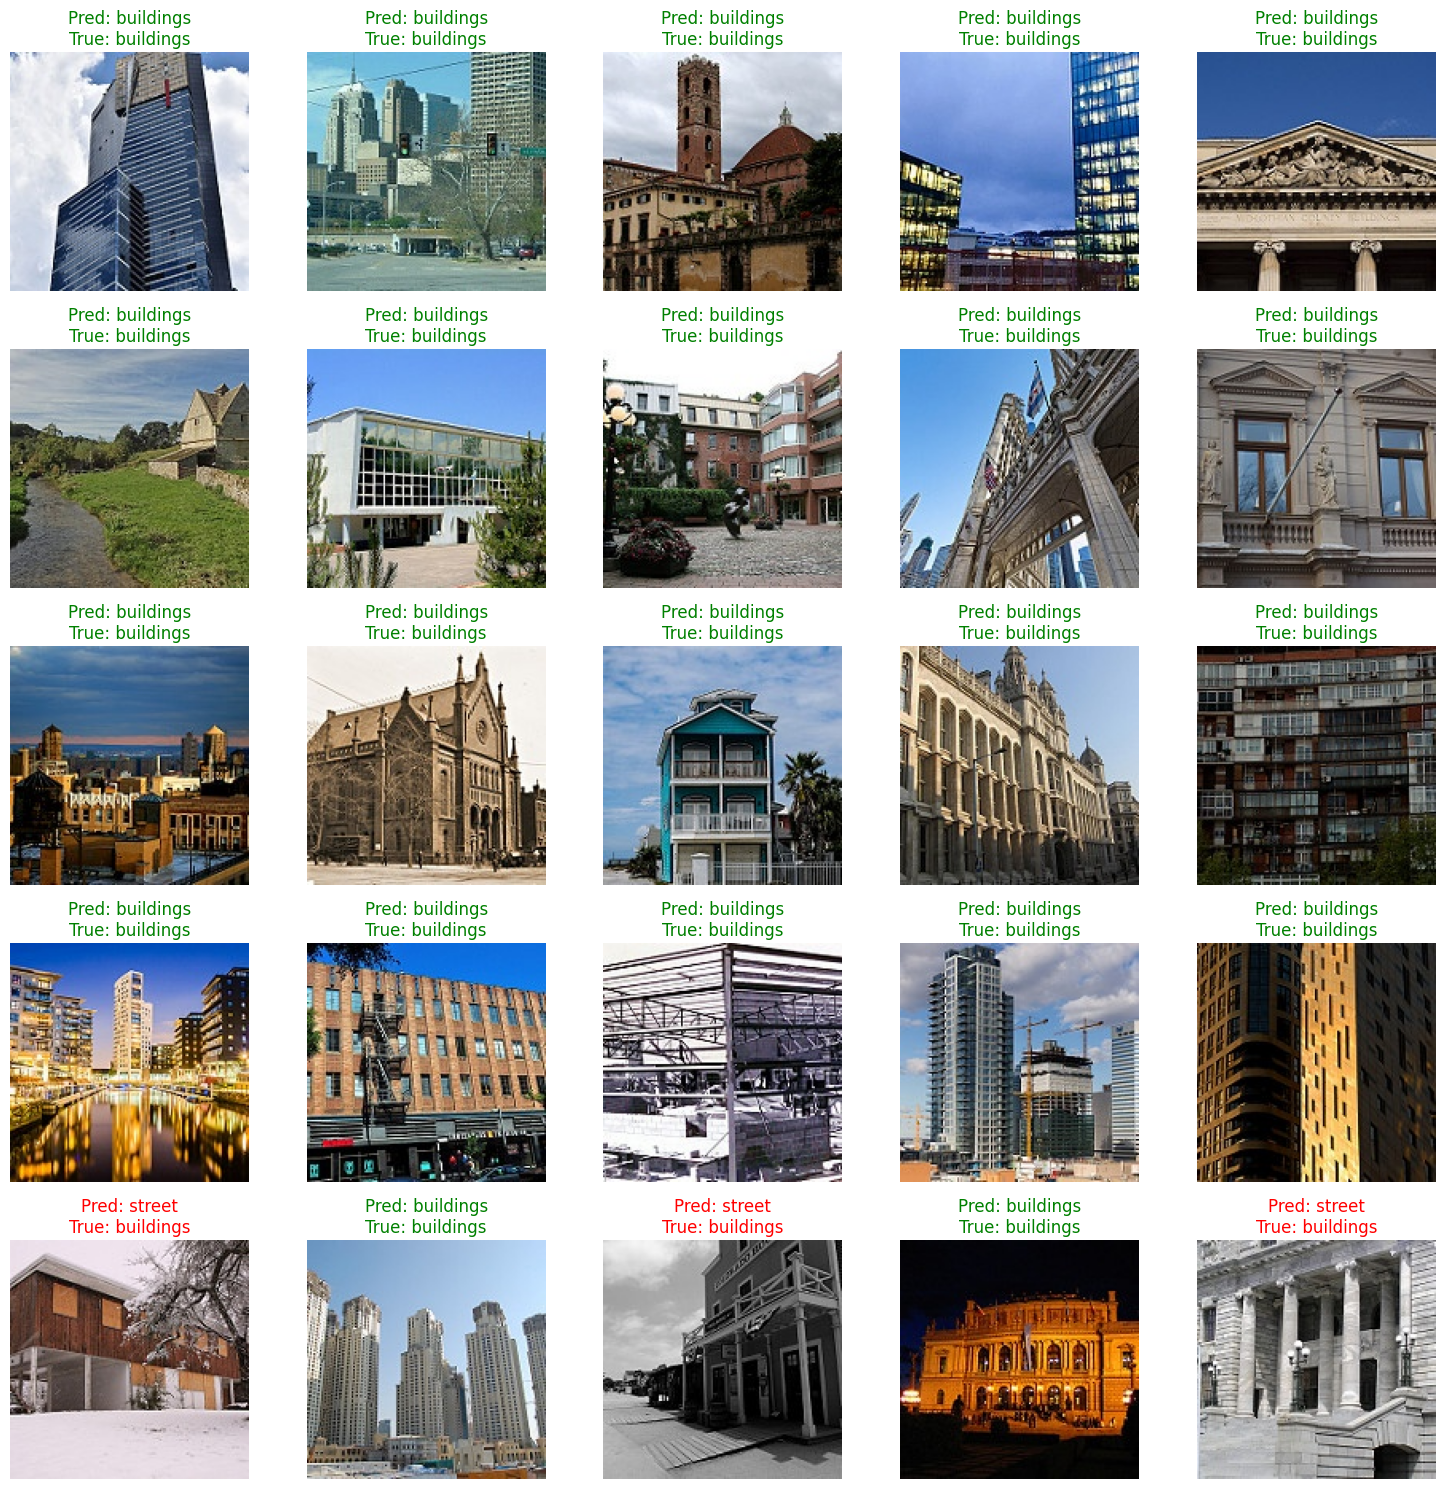

In [18]:
# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Visualize predictions
def plot_predictions(images, true_labels, pred_labels):
    plt.figure(figsize=(15, 15))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i])
        plt.axis('off')

        pred = class_names[pred_labels[i]]
        true = class_names[true_labels[i]]

        color = 'green' if pred == true else 'red'
        plt.title(f"Pred: {pred}\nTrue: {true}", color=color)
    plt.tight_layout()
    plt.show()

# Get a test batch
test_images, test_labels = next(test_generator)
test_preds = np.argmax(model.predict(test_images), axis=1)
test_true = np.argmax(test_labels, axis=1)
plot_predictions(test_images, test_true, test_preds)